In [13]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [15]:
IMG_DIR = '/kaggle/input/stanford-car-dataset-by-classes-folder'
CSV_PATH = '/kaggle/input/stanford-car-dataset-by-classes-folder/anno_test.csv'
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 10
LR = 1e-4
CROP_IMAGES = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
column_names = ["image_name", "x1", "y1", "x2", "y2", "class_id"]
df = pd.read_csv(CSV_PATH,names=column_names)
df

,image_name,x1,y1,x2,y2,class_id
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
...,...,...,...,...,...,...
8036,08037.jpg,49,57,1169,669,63
8037,08038.jpg,23,18,640,459,16
8038,08039.jpg,33,27,602,252,17
8039,08040.jpg,33,142,521,376,38


In [37]:
class CarsDataset(Dataset):
    def __init__(self, file_list, annotations_df, class_to_idx, transform=None, crop=True):
        self.samples = file_list
        self.annotations = annotations_df
        self.transform = transform
        self.crop = crop
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_name = self.samples[idx]
        label = self.class_to_idx[label_name]
        img_name = os.path.basename(img_path)
        
        image = Image.open(img_path).convert("RGB")
        if self.crop:
            bbox = self.annotations[self.annotations['image'] == img_name]
            if not bbox.empty:
                x1, y1, x2, y2 = bbox.iloc[0][['x1', 'y1', 'x2', 'y2']]
                image = image.crop((x1, y1, x2, y2))
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [38]:
column_names = ["image", "x1", "y1", "x2", "y2", "class_id"]
annotations_df = pd.read_csv('/kaggle/input/stanford-car-dataset-by-classes-folder/anno_train.csv', names=column_names)
samples = []
for root, _, files in os.walk(IMG_DIR):
    for file in files:
        if file.endswith('.jpg'):
            class_name = os.path.basename(root)
            samples.append((os.path.join(root, file), class_name))
class_names = sorted(set(cls for _, cls in samples))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

train_files, val_files = train_test_split(samples, test_size=0.2, random_state=42, stratify=[c for _, c in samples])


In [39]:
num_classes = df['class_id'].unique()
len(num_classes)

196

In [47]:

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
   # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [48]:
train_dataset = CarsDataset(train_files, annotations_df, class_to_idx,transform=train_transforms, crop=False)
val_dataset = CarsDataset(val_files, annotations_df, class_to_idx,transform=val_transforms, crop=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 and modify the final layer
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(num_classes))

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, 
                       steps_per_epoch=len(train_loader), epochs=5)

num_epochs = 5
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / train_total
    train_acc = train_correct / train_total
    print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_acc * 100:.2f}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / total
    val_acc = correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc * 100:.2f}%")

    # Step scheduler if it's per-epoch
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("✅ Best model saved.")


Epoch 1/5


100%|██████████| 405/405 [01:10<00:00,  5.78it/s]

Training Loss: 5.5956, Accuracy: 14.33%


Validation Loss: 4.5098, Accuracy: 25.73%
✅ Best model saved.

Epoch 2/5


100%|██████████| 405/405 [01:09<00:00,  5.79it/s]

Training Loss: 3.6947, Accuracy: 32.89%


Validation Loss: 4.3315, Accuracy: 32.00%
✅ Best model saved.

Epoch 3/5


100%|██████████| 405/405 [01:09<00:00,  5.82it/s]

Training Loss: 3.0726, Accuracy: 41.23%


Validation Loss: 3.9070, Accuracy: 36.36%
✅ Best model saved.

Epoch 4/5


 48%|████▊     | 194/405 [00:33<00:32,  6.43it/s]

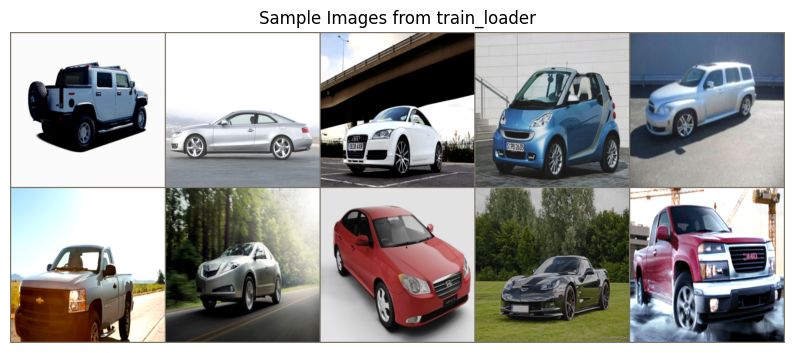

In [49]:
import matplotlib.pyplot as plt
import torchvision

# Get a batch of images and labels from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid of 10 images (un-normalized for display)
img_grid = torchvision.utils.make_grid(images[:10], nrow=5)

# Unnormalize (if you used standard ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
img_grid = img_grid * std + mean  # unnormalize

# Convert to numpy and plot
npimg = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.imshow(npimg)
plt.axis('off')
plt.title("Sample Images from train_loader")
plt.show()